<a href="https://colab.research.google.com/github/jcmachicao/pucp_energy_efficiency_AI/blob/main/03_ReinforcementLearning/temperature_regulation_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 24.8 MB/s eta 0:00:00


In [6]:
!pip install shimmy==0.2.1

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

from gym import Env
from gym.spaces import Discrete, Box
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [4]:
# Define the custom environment
class TemperatureEnv(Env):
    def __init__(self):
        # Define action and observation spaces
        self.action_space = Discrete(3)  # Actions: decrease, maintain, increase temperature
        self.observation_space = Box(low=np.array([0.0]), high=np.array([100.0]), dtype=np.float32)
        self.state = 38 + random.randint(-3, 3)  # Initial temperature
        self.shower_length = 60  # Duration of the episode in seconds

    def step(self, action):
        # Update the state based on the action
        self.state += action - 1  # Action: 0 -> decrease, 1 -> maintain, 2 -> increase
        self.shower_length -= 1

        # Calculate reward based on proximity to target temperature (38°C)
        reward = -abs(self.state - 38.0)  # Negative distance from target

        # Check if the episode is done
        done = self.shower_length <= 0

        # Add small random noise for realism
        self.state += random.uniform(-0.1, 0.1)

        # Optional: provide additional info (empty here)
        info = {}
        return np.array([self.state], dtype=np.float32), reward, done, info

    def reset(self):
        # Reset the environment to an initial state
        self.state = 38 + random.randint(-3, 3)
        self.shower_length = 60
        return np.array([self.state], dtype=np.float32)

    def render(self):
        # Rendering is not implemented in this example
        pass

In [ ]:
env = TemperatureEnv() # Create the environment
env = DummyVecEnv([lambda: env]) # Wrap the environment for Stable-Baselines3 (required for vectorized training)
model = PPO("MlpPolicy", env, verbose=1) # Create the PPO model

In [20]:
model.learn(total_timesteps=100_000) # Train the model

-----------------------------
| time/              |      |
|    fps             | 1181 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 847          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0017395401 |
|    clip_fraction        | 0.042        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.296       |
|    explained_variance   | 0.0263       |
|    learning_rate        | 0.0003       |
|    loss                 | 534          |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00426     |
|    value_loss           | 828          |
------------------------------------------
----------------

In [36]:
# Test the trained model
obs = env.reset()
done = False
temps, actions = [], []

while not done:
    action, _ = model.predict(obs)  # Predict the next action
    obs, reward, done, info = env.step(action)
    temps.append(obs[0])  # Record temperature
    actions.append(action[0])  # Record action

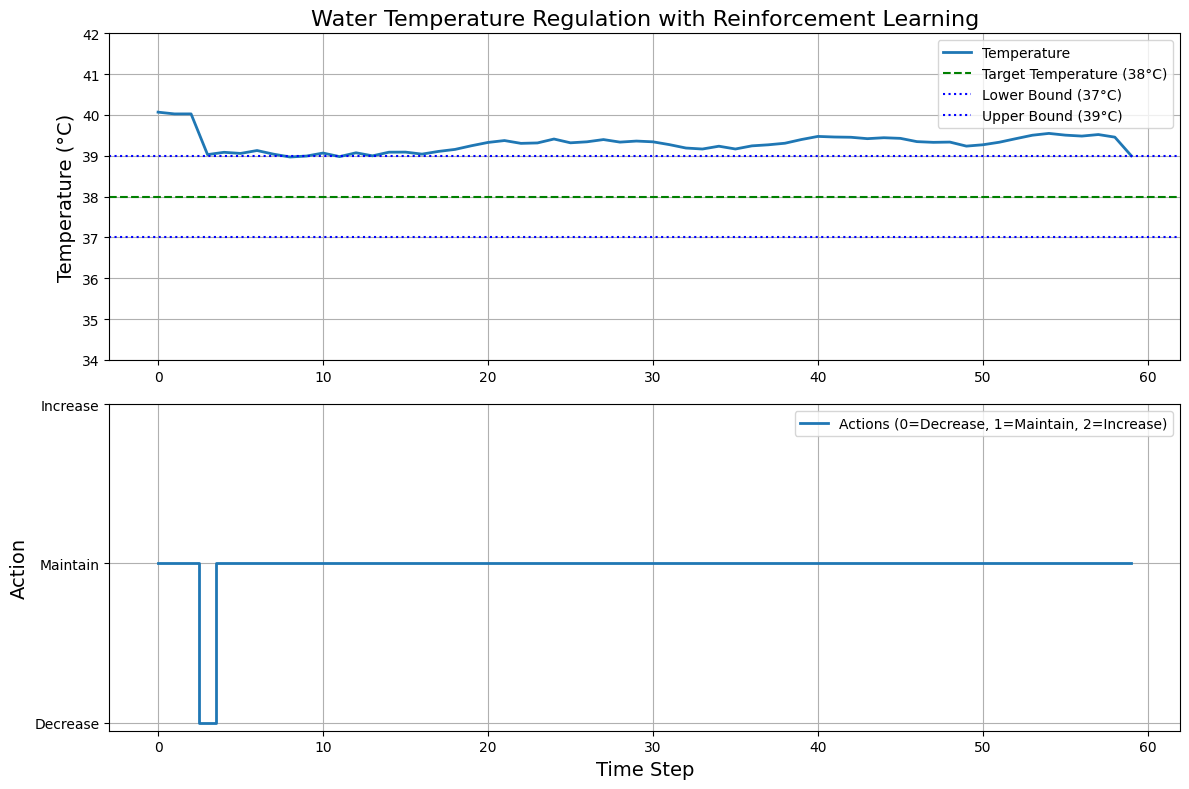

In [37]:
plt.figure(figsize=(12, 8))

# Temperature Plot
plt.subplot(2, 1, 1)  # First subplot: Temperature
plt.plot(temps, label="Temperature", lw=2)
plt.axhline(y=38, color="green", linestyle="--", label="Target Temperature (38°C)")
plt.axhline(y=37, color="blue", linestyle=":", label="Lower Bound (37°C)")
plt.axhline(y=39, color="blue", linestyle=":", label="Upper Bound (39°C)")
plt.title("Water Temperature Regulation with Reinforcement Learning", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.legend()
plt.ylim(34, 42) # Set the y-axis limits
plt.grid(True)

# Action Plot
plt.subplot(2, 1, 2)  # Second subplot: Actions
plt.step(range(len(actions)), actions, where="mid", label="Actions (0=Decrease, 1=Maintain, 2=Increase)", lw=2)
plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Action", fontsize=14)
plt.yticks([0, 1, 2], ["Decrease", "Maintain", "Increase"])
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()